# Домашнее задание

- Скачайте текст войны и мир (ссылка на [github](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.4/war_and_peace) и [гугл диск](https://drive.google.com/drive/u/2/folders/1aM7cNI6Qs7AyeYpQ8lNg7vLsHzIl0JbU)). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов
- Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [4]:
with open('tom_1.txt', 'r', encoding='utf-8') as f:
    text = f.read().lower()
text = re.sub('[^а-я]','', text)

Сначала построим матрица переходных вероятностей:

In [6]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
POS = {l: i for i, l in enumerate(RUSSIAN)}

In [8]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [10]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [11]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [12]:
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

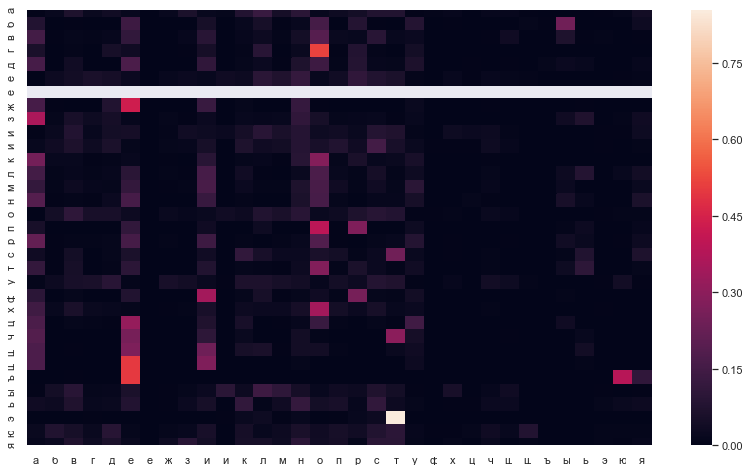

In [13]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Посчитаем вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р:

In [56]:
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIAN)
df = pd.DataFrame(columns = ['word', 'proba'])
for c in RUSSIAN:
    for l in RUSSIAN:
        proba = prior * probabilities[start, POS[c]] * probabilities[POS[c], POS[l]] * probabilities[POS[c], end]
        if proba > 0:
            print(''.join(['п', c, l, 'р']), proba)
            to_append = [''.join(['п', c, l, 'р']), proba]
            df_length = len(df)
            df.loc[df_length] = to_append

паар 3.320148995565428e-07
пабр 1.3615803332775531e-06
павр 5.004166875527701e-06
пагр 1.4781047932180703e-06
падр 2.8093568424015157e-06
паер 1.3168860198757108e-06
пажр 1.318482245354348e-06
пазр 4.463046438269681e-06
паир 1.3520029804057298e-06
пайр 7.789580335749657e-07
пакр 5.602751430016661e-06
палр 9.345900177420952e-06
памр 3.5196771803950813e-06
панр 6.782362058729569e-06
паор 1.2658068045593197e-06
папр 2.3320854242889858e-06
парр 3.2100094375394596e-06
паср 5.446321333110213e-06
патр 5.506977901298427e-06
паур 4.772714181125304e-07
пафр 6.129505837966945e-07
пахр 1.0982031293024108e-06
пацр 1.3567916568416413e-07
пачр 1.1157616095674203e-06
пашр 1.0966069038237736e-06
пащр 2.4103004727422103e-07
паэр 2.9849416450516106e-07
паюр 7.981127393186125e-07
паяр 3.0200586055816298e-06
пбар 1.4323771632666093e-08
пббр 3.6926955362368483e-10
пбвр 6.219276692609429e-10
пбгр 2.3322287597285356e-10
пбдр 2.1378763630844913e-10
пбер 2.470218961345808e-08
пбжр 9.717619832202234e-11
пбзр 3.8

Выведем топ-10 наиболее вероятных строк:

In [62]:
df.sort_values(by=['proba'], ascending=False).head(10)

,word,proba
298,повр,0.000088
309,понр,0.000076
313,поср,0.000072
314,потр,0.000066
307,полр,0.000061
312,порр,0.000057
308,помр,0.000048
300,подр,0.000046
299,погр,0.000045
159,пенр,0.000044


Теперь попробуем сгенировать слово, используя матрицу переходных вероятностей, начинающееся с буквы "Б" и имеющее длину 8-мь символов

In [63]:
s = []
start = 'б'
s.append(start)
length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print(''.join(s))

бысьцулис


### Попробуем оценить через HMM ряд индекса акций S&P 500 c 2000 года по 2020 гг.

In [80]:
series = pd.read_excel("spx500_daily_price.xlsx")['Close']

In [81]:
series

0       1417.04
1       1415.22
2       1403.17
3       1413.32
4       1418.78
         ...   
5146    3036.13
5147    3029.73
5148    3044.31
5149    3055.73
5150    3080.82
Name: Close, Length: 5151, dtype: float64

In [82]:
from hmmlearn.hmm import GaussianHMM

In [83]:
values = series.values.reshape(-1,1)

Выберем кол-во компонент:

In [85]:
for n in range(1, 15):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -40372.04117073129
2 -35819.991996515884
3 -33907.55207230027
4 -32514.61495442558
5 -31211.742093646553
6 -30247.745124984744
7 -29639.69087405695
8 -29244.73326213074
9 -28489.251910506264
10 -28303.891993116064
11 -27914.49143553666
12 -27460.559377974987
13 -27455.57378775411
14 -26944.409162280757


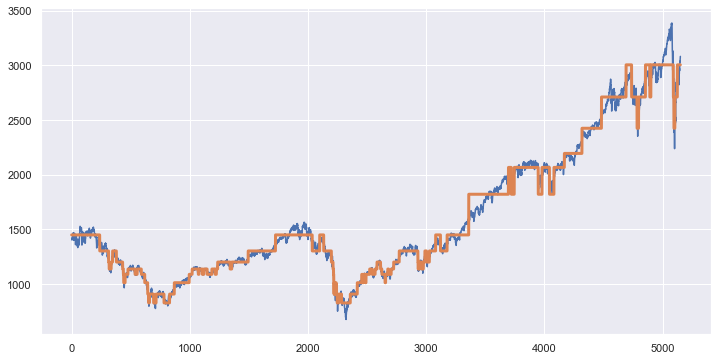

In [86]:
model = GaussianHMM(n_components=14,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

In [87]:
model.transmat_.shape

(14, 14)

Нарисуем динамику каждой из компоненты:

In [115]:
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator

In [116]:
dates = series['Date'][1:]
close_v = series['Close'][1:]

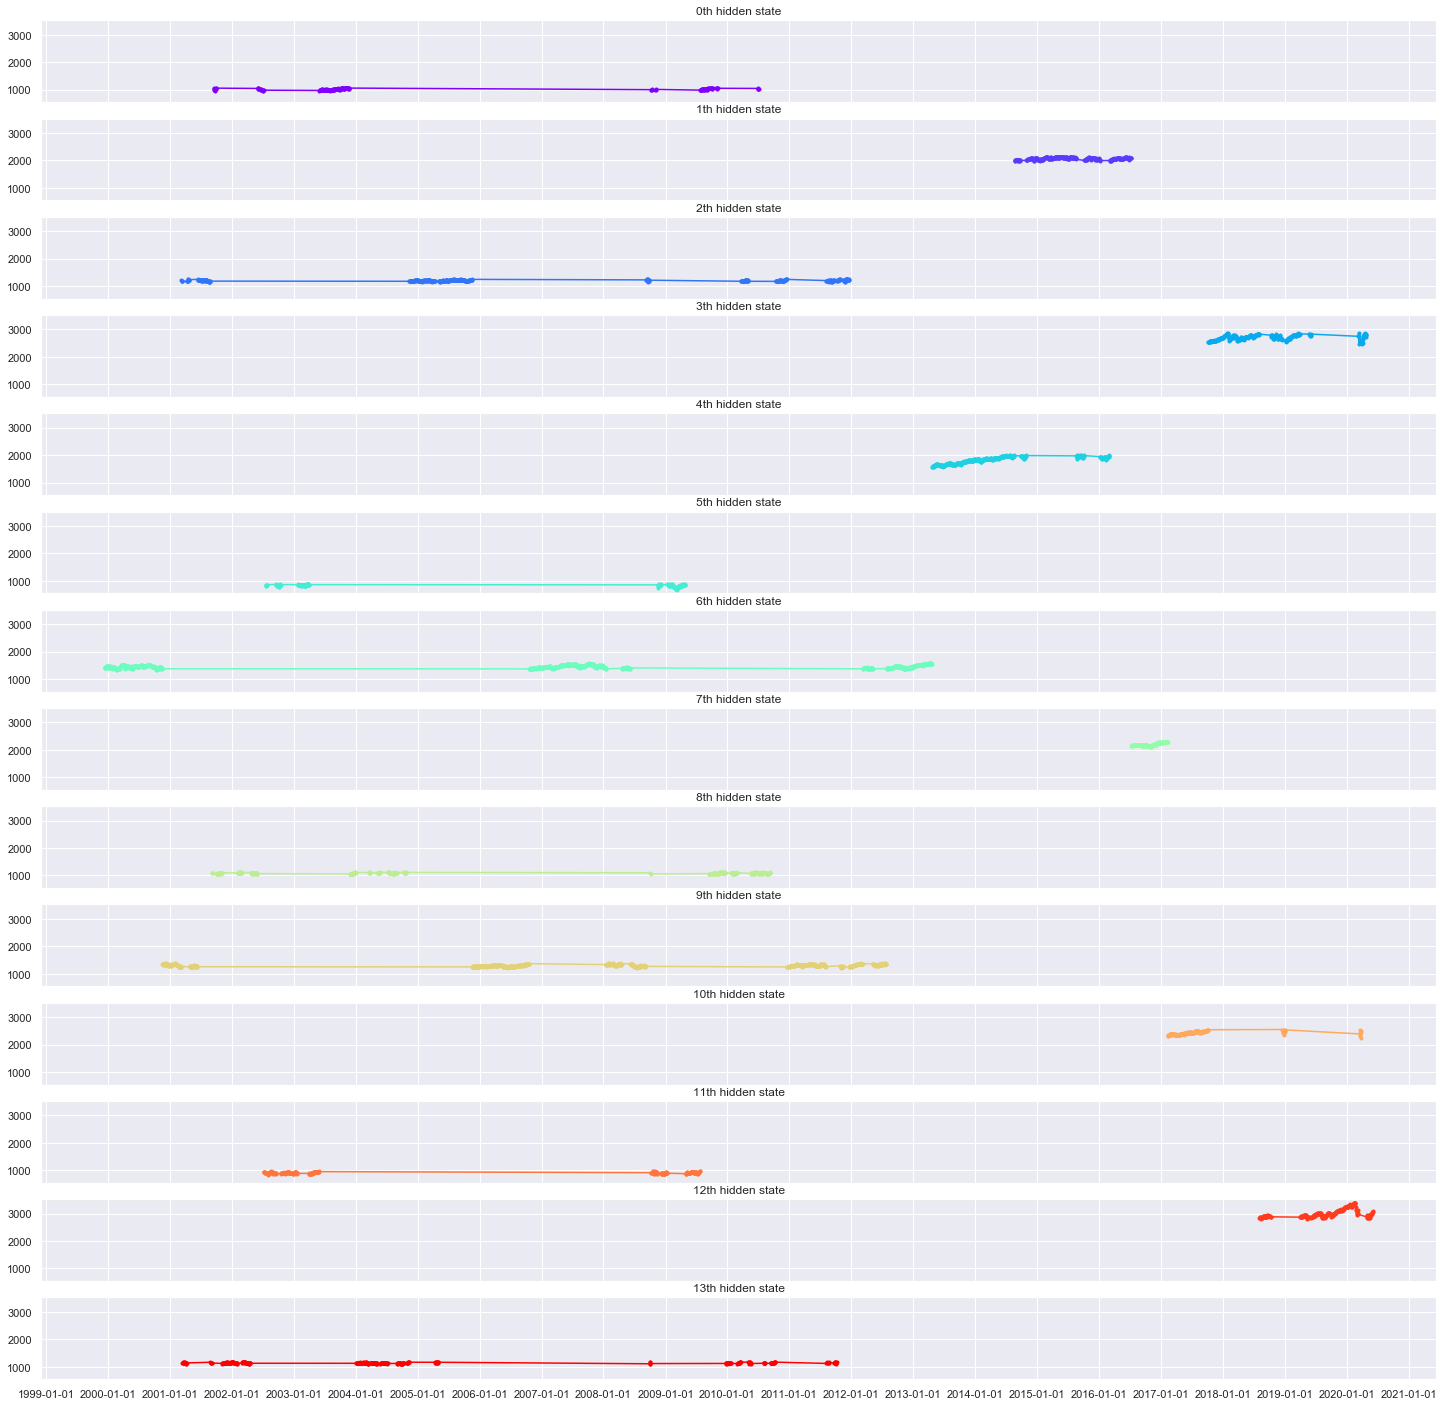

In [129]:
fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(25,25))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = labels[1:] == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

plt.show()

In [159]:
from sklearn.utils import check_random_state
transmat_cdf = np.cumsum(model.transmat_, axis=1)
random_state = check_random_state(model.random_state)
next_state = (transmat_cdf[labels[-1]] > random_state.rand()).argmax()
prob_next_step = model.transmat_[labels[-1], :]

print('Next state will be {}'.format(next_state))
print('The probability of this state is {}'.format(prob_next_step[0]))

Next state will be 8
The probability of this state is 0.07142857142857142


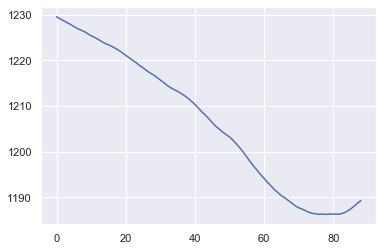

In [177]:
plt.plot(model.means_[next_state])